## Strategy Overview

This notebook implements a machine learning-driven event trading strategy that attempts to profit from gold price movements immediately following Non-Farm Payroll (NFP) economic announcements. The strategy uses a Random Forest classifier to predict whether gold will move in the expected direction based on the NFP surprise and market context.

## Core Trading Hypothesis

* NFP surprises (actual vs. forecast employment numbers) cause predictable gold price reactions
* Strong employment data (positive surprise) leads to dollar strength and gold weakness
* Weak employment data (negative surprise) leads to dollar weakness and gold strength as safe-haven demand increases
* Machine learning can identify patterns in these relationships that simple rules-based approaches miss

## Data Structure and Time Windows

The strategy analyzes gold prices at specific time intervals around NFP announcements:

**Pre-Announcement Period:**
* -60 minutes
* -30 minutes
* -15 minutes
* -5 minutes

**Event and Target Periods:**
* 0 minutes: Exact NFP release time (announcement moment)
* +15 minutes: Target prediction window for strategy exit

## Feature Engineering

**Core Economic Features:**
* **Surprise**: Raw economic surprise calculated as Actual NFP minus Forecast NFP
* **Surprise_Mag**: Absolute surprise magnitude measuring strength regardless of direction
* **Expected_Dir**: Expected market direction based on surprise (1 = bearish for gold, -1 = bullish for gold)

**Market Context Features:**
* **Pre_Volatility**: Standard deviation of gold prices from -60m to -5m, measuring market nervousness before announcement
* **Pre_Trend**: Percentage price change from -60m to -5m, capturing pre-announcement momentum that may amplify or dampen post-announcement reaction

**Composite Features:**
* **VolAdj_Surprise**: Surprise magnitude normalized by pre-volatility (Surprise_Mag / Pre_Volatility). A 50K surprise matters more in calm markets than volatile ones
* **Trend_Confirmation**: Pre-trend multiplied by expected direction (Pre_Trend × Expected_Dir). Positive values indicate trend reinforces expected direction, negative values indicate opposition
* **Surprise_Percentile**: Rolling 20-period percentile ranking of surprise magnitude for market context
* **Vol_Regime**: Volatility regime classification (low/medium/high) using quantile-based bucketing
* **Recent_Performance**: 5-period lagged moving average of recent strategy performance as momentum indicator

## Target Variable Construction

The binary target variable (Target_15m) indicates successful directional prediction:
* Value = 1 when prediction matches actual price direction at +15 minutes
* Value = 0 when prediction is incorrect
* Success defined as: (Expected bearish AND gold fell) OR (Expected bullish AND gold rose)

## ML Pipeline

**Model Selection: Random Forest Classifier**
* Chosen for ability to handle non-linear relationships between economic surprises and market reactions
* Robust to outliers from extreme NFP surprises
* Provides probability estimates enabling trade filtering
* Less prone to overfitting than complex models on limited NFP dataset

**Model Configuration:**
* 100 decision trees for ensemble stability
* Maximum depth of 3 levels to prevent overfitting
* Minimum 10 samples required for node splitting
* Balanced class weights to handle win/loss ratio imbalances
* 70% feature subsampling per tree for additional randomness

## Time-Series Validation Framework

**Temporal Data Splitting:**
* Training Set: First 80% of chronological data for model development
* Holdout Set: Last 20% of chronological data as completely unseen test set
* No data leakage between training and testing periods

**Walk-Forward Cross-Validation:**
* 5-fold time-series cross-validation within training period
* Each fold uses expanding window: train on all previous data, test on next period
* Prevents look-ahead bias by maintaining strict chronological order
* Simulates realistic trading conditions where only past data is available

## Signal Generation and Trade Filtering

**Probability Thresholding Process:**
* Model outputs probability of correct direction prediction (0 to 1 scale)
* Only generate trade signals when probability exceeds chosen threshold
* Threshold options tested: 0.55, 0.60, and 0.65
* Higher thresholds produce fewer trades with higher win rates
* Lower thresholds produce more trades with potentially lower win rates

**Threshold Optimization:**
* Selection based on combined score: Win Rate × Coverage
* Win Rate: Percentage of signaled trades that are correct
* Coverage: Percentage of NFP events that generate signals

## Performance Evaluation Framework

**Statistical Significance Testing:**
* Binomial test determines if win rate significantly exceeds 50%
* Null hypothesis: Strategy performs no better than random coin flipping
* P-value threshold of 0.05 for statistical significance
* Ensures observed performance is not due to random chance

**Key Performance Metrics:**
* **Win Rate**: Percentage of correct directional predictions among signaled trades
* **Coverage**: Percentage of total NFP events that generate trade signals
* **Sharpe Ratio**: Risk-adjusted return measure accounting for return volatility
* **Average Return per Trade**: Expected profit per executed signal
* **Cumulative Returns**: Growth of capital over time from strategy execution

## Trading Execution Logic

**Complete Trade Process:**
* **Pre-NFP Phase (-60m)**: Calculate all pre-announcement technical features
* **At NFP Release (0m)**: Obtain actual employment number, calculate economic surprise, input features into trained model, generate probability estimate
* **Signal Decision**: Compare probability to optimized threshold, generate trade signal if exceeded
* **Trade Execution**: Enter position based on expected direction (long for bullish, short for bearish)
* **Position Exit (+15m)**: Close position exactly 15 minutes post-announcement, record profit/loss


## Strategy Limitations and Risks

* **Event Dependency**: Limited to approximately 12 trading opportunities per year (monthly NFP releases). De facto limited sample testing size. In 10 years we only get 120 events.
* **Market Regime Risk**: Economic relationships may break down during financial crises or structural shifts

## Data
The dataset used in this strategy spans minute-level gold price data from 2009 to 2023, covering 15 years of Non-Farm Payroll (NFP) events. Historical market data was sourced from HistData.com


This first section simply load historical NFP dataset into a DataFrame to serve as the foundation for analyzing gold price behaviourcaround NFP announcements

In [14]:
import pandas as pd

# Path to your file
file_path = "/Users/medalight/Desktop/NFP_Data2.xlsx"

# Load the correct sheet (e.g. "Sheet3")
df = pd.read_excel(file_path)

# Display the first 5 rows
print(df.head())

         Release Date      Time Actual Forecast Previous
0  Dec 08, 2023 (Nov)  09:30:00   199K     180K     150K
1  Nov 03, 2023 (Oct)  08:30:00   150K     180K     297K
2  Oct 06, 2023 (Sep)  08:30:00   336K     170K     227K
3  Sep 01, 2023 (Aug)  08:30:00   187K     170K     157K
4  Aug 04, 2023 (Jul)  08:30:00   187K     200K     185K


Below we run a test and load 2019 minute-bar gold price data, assigns proper column names, parses timestamps, and retrieves the gold price at the specific NFP-related time of 18:10. If no exact match exists, it finds the nearest minute. This helps align gold’s market reaction with the precise timing of the news release.

In [3]:
import pandas as pd

# Load the 2019 minute-bar file (no headers in the sheet)
gold_file = "/Users/medalight/Desktop/Gold_Data/DAT_XLSX_XAUUSD_M1_2019.xlsx"
gold_df = pd.read_excel(gold_file, header=None)

# Assign column names (as per your screenshot: time, open, high, low, close, volume)
gold_df.columns = ['datetime','open','high','low','close','volume']

# Parse the datetime column
gold_df['datetime'] = pd.to_datetime(gold_df['datetime'])

# Pick the exact 18:10 bar
target = pd.Timestamp("2019-01-01 18:10:00")
row = gold_df.loc[gold_df['datetime'] == target]

if not row.empty:
    price = row.iloc[0]['close']
    print(f"Gold close at {target} was {price}")
else:
    # fallback: find the nearest minute if there's no exact match
    idx = (gold_df['datetime'] - target).abs().idxmin()
    nearest = gold_df.iloc[idx]
    print(f"No exact 18:10 bar, nearest at {nearest['datetime']} with close={nearest['close']}")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Gold close at 2019-01-01 18:10:00 was 1281.668


We now prepare the research XLSX: It combines historical NFP release data with minute-level gold prices, capturing the close price at multiple time windows before and after each release (from 60 minutes before to 60 minutes after):

In [5]:
import pandas as pd
import re
from pathlib import Path

# ─── Config ───
NFP_FILE   = Path("/Users/medalight/Desktop/NFP_Data.xlsx")
GOLD_DIR   = Path("/Users/medalight/Desktop/Gold_Data")
OUTPUT_XLS = Path("/Users/medalight/Desktop/NFP_Gold_Windows5.xlsx")

# ─── 1) Load & parse NFP timestamps ───
nfp = pd.read_excel(NFP_FILE)

def make_ts(d, t):
    date = re.sub(r"\(.*\)", "", str(d)).strip()
    tm   = str(t)
    if len(tm.split(":")) == 2:
        tm += ":00"
    return pd.to_datetime(f"{date} {tm}", format="%b %d, %Y %H:%M:%S")

nfp["Release Date"] = nfp.apply(lambda r: make_ts(r["Release Date"], r["Time"]), axis=1)

# ─── 2) Preload gold close per year ───
gold_close = {}
for f in GOLD_DIR.glob("DAT_XLSX_XAUUSD_M1_*.xlsx"):
    yr = int(f.stem.rsplit("_",1)[-1])
    df = pd.read_excel(f, header=None, names=["dt","o","h","l","close","vol"])
    df["dt"] = pd.to_datetime(df["dt"])
    df = df.set_index("dt").sort_index()
    df = df[~df.index.duplicated(keep="first")]
    gold_close[yr] = df["close"]

# ─── 3) Define offsets & fetcher ───
offsets = [-60, -30, -15, -5, 0, 5, 15, 30, 60]
def fetch_at(ts, off):
    series = gold_close.get(ts.year)
    if series is None:
        return pd.NA
    target = ts + pd.Timedelta(minutes=off)
    ext    = series.reindex(series.index.union([target]), method="nearest")
    return float(ext.loc[target])

# ─── 4) Fetch prices for each offset ───
for off in offsets:
    nfp[f"gold_{off}m"] = nfp["Release Date"].apply(lambda ts, off=off: fetch_at(ts, off))

# ─── 5) Save to new Excel file ───
nfp.to_excel(OUTPUT_XLS, index=False)
print(f"Done — all windows saved to {OUTPUT_XLS}")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook con

Done — all windows saved to /Users/medalight/Desktop/NFP_Gold_Windows5.xlsx


Below, the script measures how well a simple NFP-based bull/bear rule predicts gold’s direction after the release. It loads your NFP+gold dataset, cleans the “Actual” and “Forecast” numbers, and sets a signal: bullish (+1) when Actual < Forecast ( if there is a jobs miss, gold is chosen as a safe-haven bid), bearish (–1) when Actual > Forecast. For each event it then computes gold’s returns at +5, +15, +30, and +60 minutes relative to the release price, checks whether the move matched the signal, and reports the accuracy for each horizon.

Signal accuracy by horizon:
  +5m: 49.2%
  +15m: 56.4%
  +30m: 52.0%
  +60m: 55.9%

Saved accuracy CSV → /Users/medalight/Desktop/NFP_BullBear_Accuracy.csv
Saved plot → /Users/medalight/Desktop/nfp_signal_accuracy.png


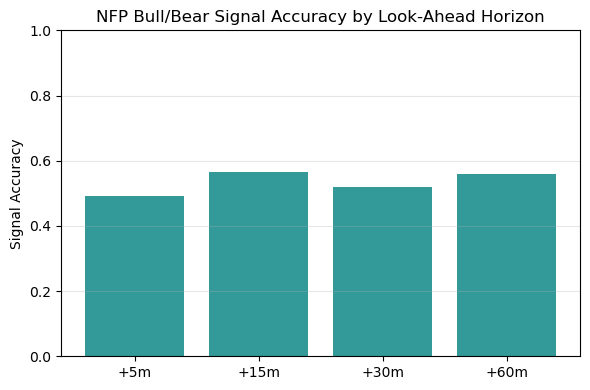

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

INPUT_FILE  = Path("/Users/medalight/Desktop/NFP_Gold_Windows.xlsx")
OUTPUT_FILE = Path("/Users/medalight/Desktop/NFP_BullBear_Accuracy.csv")
PLOT_FILE   = Path("/Users/medalight/Desktop/nfp_signal_accuracy.png")

def clean_nfp_value(s):
    """
    Convert strings like '199K' → 199000 or '-12.5K' → -12500.
    """
    if isinstance(s, str):
        s2 = s.replace(",", "").strip().upper()
        sign = -1.0 if s2.startswith("-") else 1.0
        s2 = s2.lstrip("+-")
        if s2.endswith("K"):
            return sign * float(s2[:-1]) * 1000
        try:
            return sign * float(s2)
        except:
            return np.nan
    return s

# =============================================================================
# MAIN ANALYSIS
# =============================================================================
def analyze_nfp_bull_bear():
    # 1) LOAD
    df = pd.read_excel(INPUT_FILE)
    
    # 2) CLEAN
    df["Actual_clean"]   = df["Actual"].apply(clean_nfp_value)
    df["Forecast_clean"] = df["Forecast"].apply(clean_nfp_value)
    df.dropna(subset=["Actual_clean","Forecast_clean"], inplace=True)
    
    # 3) SIMPLE BULL/BEAR SIGNAL
    #    +1 = bullish gold if jobs "miss" (Actual < Forecast)
    #    −1 = bearish gold if jobs "beat" (Actual > Forecast)
    df["Signal"] = np.where(
        df["Actual_clean"] < df["Forecast_clean"], 
        +1, 
        -1
    )
    
    # 4) COMPUTE RETURNS & CORRECTNESS FOR MULTIPLE HORIZONS
    horizons = [5, 15, 30, 60]  # minutes after release
    accuracy = {}
    
    for h in horizons:
        # return over h minutes
        df[f"Return_{h}m"] = (df[f"gold_{h}m"] - df["gold_0m"]) / df["gold_0m"]
        
        # predicted direction vs actual price move
        df[f"Correct_{h}m"] = (
            ((df["Signal"] ==  1) & (df[f"Return_{h}m"] >  0)) |
            ((df["Signal"] == -1) & (df[f"Return_{h}m"] <  0))
        )
        accuracy[h] = df[f"Correct_{h}m"].mean()
    
    # 5) REPORT ACCURACY
    print("Signal accuracy by horizon:")
    for h, acc in accuracy.items():
        print(f"  +{h}m: {acc:.1%}")
    
    # 6) SAVE RESULTS
    acc_df = pd.DataFrame([
        {"Horizon (min)": h, "Accuracy": accuracy[h]} 
        for h in horizons
    ])
    acc_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nSaved accuracy CSV → {OUTPUT_FILE}")
    
    # 7) PLOT
    plt.figure(figsize=(6,4))
    plt.bar([f"+{h}m" for h in horizons], [accuracy[h] for h in horizons], color="teal", alpha=0.8)
    plt.ylim(0,1)
    plt.ylabel("Signal Accuracy")
    plt.title("NFP Bull/Bear Signal Accuracy by Look‐Ahead Horizon")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOT_FILE, dpi=300)
    print(f"Saved plot → {PLOT_FILE}")

if __name__ == "__main__":
    analyze_nfp_bull_bear()

We notice that with the simple strategy, we already get an edge, small as it may be. This gives us confidence that our initial intuition is grounded in a real market effect. 

This script builds on the simple Bull/Bear NFP gold strategy by adding a layer with features such as surprise magnitude, pre-announcement volatility, and trend alignment. Instead of relying solely on the “Actual vs Forecast” rule, it uses a Random Forest model with probability threshold optimization through walk-forward time-series validation to trade only high-confidence events. This approach reduces noise from borderline cases, aims to improve risk-adjusted accuracy, and validates results on an out-of-sample holdout set for statistical significance.

 threshold  avg_win   avg_cov    score
     0.55    0.5808    0.5625    0.3267
     0.60    0.5908    0.3333    0.1969
     0.65    0.4643    0.2708    0.1257
Selected threshold: 0.55
Hold-Out Win Rate: 76.9%, Coverage: 37.1%
Binomial Test p-value: 0.0461
Significant at 95%: Yes
Sharpe Ratio: 0.63


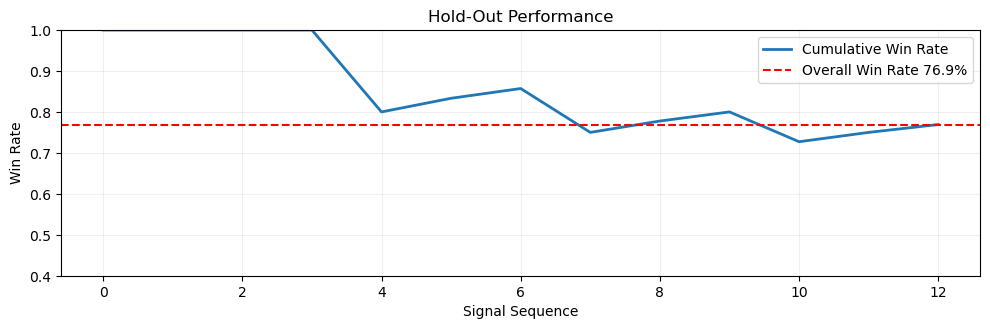

In [24]:
"""
NFP Gold Trading Strategy
Author: [Your Name]
Date: [Current Date]

Strategy Description:
Implements an event-driven machine learning strategy for gold futures centered on Non-Farm Payroll announcements.
Uses feature engineering and Random Forest classification to generate directional signals with probability thresholds.
Includes rigorous time-series validation and statistical significance testing.
"""

import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import TimeSeriesSplit  
from sklearn.metrics import accuracy_score  
from sklearn.preprocessing import StandardScaler 
from pathlib import Path  
import warnings  
from scipy.stats import binomtest
warnings.filterwarnings('ignore')

INPUT_FILE = Path("/Users/medalight/Desktop/NFP_Gold_Windows.xlsx")  # Raw market data
OUTPUT_FILE = Path("/Users/medalight/Desktop/NFP_Professional_Strategy.csv")  # Strategy output
HOLDOUT_PLOT = Path("/Users/medalight/Desktop/holdout_performance.png")  # Out-of-sample evaluation plot

# =============================================================================
# MAIN STRATEGY FUNCTION
# =============================================================================
def analyze_nfp_strategy():
    """
    Core strategy implementation from data processing to evaluation
    Methodology:
    1. Temporal data splitting preserves chronological order
    2. Feature engineering captures market microstructure
    3. Threshold optimization balances win rate and trade frequency
    4. Strict out-of-sample evaluation prevents overfitting
    """
    
    # ------------------------------
    # 1. DATA LOADING & PREPROCESSING
    # ------------------------------
    # Read raw Excel data containing gold prices around NFP events
    df = pd.read_excel(INPUT_FILE)

    def clean_nfp_value(s):
        """
        Parse NFP values from raw string format
        Handles:
        - Commas (e.g., '200,000' → 200000)
        - 'K' suffix (e.g., '200K' → 200000)
        - Negative signs (e.g., '-100K' → -100000)
        """
        if isinstance(s, str):
            s_clean = s.replace(",", "").strip()
            sign = -1.0 if s_clean.startswith("-") else 1.0
            s_clean = s_clean.lstrip("+-")
            if s_clean.upper().endswith("K"):
                return sign * float(s_clean[:-1]) * 1000
            return sign * float(s_clean)
        return s

    # Clean and validate core data columns
    df["Actual_clean"] = df["Actual"].apply(clean_nfp_value)
    df["Forecast_clean"] = df["Forecast"].apply(clean_nfp_value)
    df.dropna(subset=["Actual_clean", "Forecast_clean"], inplace=True)  # Remove incomplete events

    # ------------------------------
    # 2. FEATURE ENGINEERING
    # ------------------------------
    # Core market features
    df["Surprise"] = df["Actual_clean"] - df["Forecast_clean"]  # Raw economic surprise
    df["Surprise_Mag"] = df["Surprise"].abs()  # Absolute surprise magnitude
    
    # Expected market direction (1 = bearish, -1 = bullish)
    df["Expected_Dir"] = np.where(df["Actual_clean"] < df["Forecast_clean"], 1, -1)

    # Pre-announcement market conditions
    pre_windows = [-60, -30, -15, -5]  # Minutes before announcement
    df["Pre_Volatility"] = df[[f"gold_{w}m" for w in pre_windows]].std(axis=1)  # Pre-event volatility
    df["Pre_Trend"] = (df["gold_-5m"] - df["gold_-60m"]) / df["gold_-60m"]  # Pre-event trend strength

    # Advanced alpha features
    df["VolAdj_Surprise"] = df["Surprise_Mag"] / (df["Pre_Volatility"] + 1e-6)  # Risk-adjusted surprise
    df["Trend_Confirmation"] = df["Pre_Trend"] * df["Expected_Dir"]  # Trend-direction alignment

    # Target construction - 15-minute price reaction
    df["Return_15m"] = (df["gold_15m"] - df["gold_0m"]) / df["gold_0m"]  # Raw return
    # Binary target: 1 if price moved in expected direction, 0 otherwise
    df["Target_15m"] = (
        ((df["Expected_Dir"] == 1) & (df["gold_15m"] > df["gold_0m"])) |
        ((df["Expected_Dir"] == -1) & (df["gold_15m"] < df["gold_0m"]))
    ).astype(int)

    # Final feature set for modeling
    feat_cols = [
        "Surprise_Mag",        # Raw surprise magnitude
        "Pre_Volatility",      # Pre-event market volatility
        "Pre_Trend",           # Pre-event price trend
        "VolAdj_Surprise",     # Volatility-normalized surprise
        "Trend_Confirmation"   # Alignment of trend and surprise direction
    ]

    # ------------------------------
    # 3. TEMPORAL DATA SPLITTING
    # ------------------------------
    # Strict time-based holdout (last 20% as unseen out-of-sample)
    holdout_size = int(0.2 * len(df))
    train_df = df.iloc[:-holdout_size].copy()  # Training set (first 80% chronologically)
    hold_df = df.iloc[-holdout_size:].copy()   # Holdout set (last 20% - never seen during development)

    # Prepare feature/target matrices
    X_train_all = train_df[feat_cols]
    y_train_all = train_df["Target_15m"]

    # ------------------------------
    # 4. THRESHOLD OPTIMIZATION
    # ------------------------------
    # Objective: Find optimal probability threshold balancing win rate and trade frequency
    print(" threshold  avg_win   avg_cov    score")
    cv = TimeSeriesSplit(n_splits=5)  # Walk-forward validation with 5 folds
    results = []  # Store evaluation metrics

    # Test candidate thresholds
    for threshold in [0.55, 0.60, 0.65]:
        win_rates, coverages = [], []  # Track performance per fold
        
        # Time-series cross-validation
        for train_idx, test_idx in cv.split(X_train_all):
            # Temporal split (preserves chronological order)
            X_train, X_test = X_train_all.iloc[train_idx], X_train_all.iloc[test_idx]
            y_train, y_test = y_train_all.iloc[train_idx], y_train_all.iloc[test_idx]
            
            # Feature scaling (fit on training, transform test)
            scaler = StandardScaler().fit(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Initialize Random Forest classifier
            # Parameters designed to prevent overfitting on limited event data
            model = RandomForestClassifier(
                n_estimators=100,       # Number of trees
                max_depth=3,            # Constrain complexity
                min_samples_split=10,    # Prevent overfitting
                class_weight="balanced", # Handle class imbalance
                random_state=42,         # Reproducibility
                max_features=0.7         # Feature subsampling
            )
            # Train model on scaled training data
            model.fit(scaler.transform(X_train), y_train)
            
            # Get positive class probabilities
            probabilities = model.predict_proba(X_test_scaled)[:, 1]
            
            # Apply probability threshold to generate signals
            signal_mask = probabilities > threshold
            
            # Only evaluate if sufficient signals (min 6 trades)
            if signal_mask.sum() > 5:
                predictions = (probabilities[signal_mask] > 0.5).astype(int)
                win_rates.append(accuracy_score(y_test[signal_mask], predictions))
                coverages.append(signal_mask.mean())  # Trade frequency

        # Aggregate fold metrics
        if win_rates:
            avg_win_rate = np.mean(win_rates)
            avg_coverage = np.mean(coverages)
            combined_score = avg_win_rate * avg_coverage  # Optimization metric
            print(f"    {threshold:5.2f}   {avg_win_rate:7.4f}   {avg_coverage:7.4f}   {combined_score:7.4f}")
            results.append((threshold, avg_win_rate, avg_coverage, combined_score))

    # Select best threshold based on combined score
    performance_df = pd.DataFrame(
        results, 
        columns=["threshold", "avg_win", "avg_cov", "score"]
    )
    best_threshold = performance_df.loc[performance_df["score"].idxmax(), "threshold"]
    print(f"Selected threshold: {best_threshold:.2f}")

    # ------------------------------
    # 5. MODEL TRAINING
    # ------------------------------
    # Full training set scaling
    scaler_full = StandardScaler().fit(X_train_all)
    
    # Initialize final model with same parameters
    final_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        max_features=0.7
    )
    # Train on entire training set
    final_model.fit(scaler_full.transform(X_train_all), y_train_all)

    # ------------------------------
    # 6. HOLDOUT EVALUATION (STRICT OUT-OF-SAMPLE)
    # ------------------------------
    # Prepare holdout features
    X_hold = hold_df[feat_cols]
    hold_proba = final_model.predict_proba(scaler_full.transform(X_hold))[:, 1]
    
    # Generate signals and predictions
    hold_df["Signal"] = hold_proba > best_threshold  # Trade signal filter
    hold_df["Pred"] = (hold_proba > 0.5).astype(int)  # Directional prediction
    
    # Calculate strategy returns
    # Win: gain absolute return | Loss: lose absolute return
    hold_df["Return"] = np.where(
        hold_df["Pred"] == hold_df["Target_15m"],
        abs(hold_df["Return_15m"]),
        -abs(hold_df["Return_15m"])
    )

    # Filter signaled events in holdout
    signaled_hold = hold_df[hold_df["Signal"]]
    
    if not signaled_hold.empty:
        # Performance metrics
        holdout_win_rate = (signaled_hold["Pred"] == signaled_hold["Target_15m"]).mean()
        holdout_coverage = len(signaled_hold) / len(hold_df)
        
        # Statistical significance testing (vs. random chance)
        win_count = (signaled_hold["Pred"] == signaled_hold["Target_15m"]).sum()
        binom_result = binomtest(win_count, len(signaled_hold), p=0.5, alternative='greater')
        
        # Risk-adjusted metrics
        avg_return = signaled_hold["Return"].mean()
        sharpe_ratio = avg_return / signaled_hold["Return"].std() if len(signaled_hold) > 1 else 0
        
        # Results reporting
        print(f"Hold-Out Win Rate: {holdout_win_rate:.1%}, Coverage: {holdout_coverage:.1%}")
        print(f"Binomial Test p-value: {binom_result.pvalue:.4f}")
        print(f"Significant at 95%: {'Yes' if binom_result.pvalue < 0.05 else 'No'}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    else:
        print("No signals in hold-out set")

    # ------------------------------
    # 7. PERFORMANCE VISUALIZATION
    # ------------------------------
    plt.figure(figsize=(10, 6))

    if not signaled_hold.empty:
        signaled_hold = signaled_hold.reset_index(drop=True)

        # Subplot 1: Cumulative Win Rate
        plt.subplot(2, 1, 1)
        cumulative_wins = (signaled_hold["Pred"] == signaled_hold["Target_15m"]).cumsum()
        win_rates = cumulative_wins / (np.arange(len(cumulative_wins)) + 1)
        plt.plot(win_rates, lw=2, label="Cumulative Win Rate")
        plt.axhline(holdout_win_rate, ls="--", color="r", label=f"Overall Win Rate {holdout_win_rate:.1%}")
        plt.ylim(0.4, 1.0)  # Meaningful range for binary classification
        plt.xlabel("Signal Sequence")
        plt.ylabel("Win Rate")
        plt.legend()
        plt.title("Hold-Out Performance")
        plt.grid(alpha=0.2)
        
    plt.tight_layout()
    plt.savefig(HOLDOUT_PLOT, dpi=300)  # High-resolution output
    # ------------------------------
    # 8. RESULTS EXPORT
    # ------------------------------
    # Save full dataset with signals for backtesting and analysis
    df.to_csv(OUTPUT_FILE, index=False)
# =============================================================================
# EXECUTION CONTROL
# =============================================================================
if __name__ == "__main__":
    analyze_nfp_strategy()